*CREDIT DEFAULT PREDICTION:* **Part I - From Raw Data to Model Selection**



# Getting data ready

##Acknowledgements

The goal of this excercise is to use Machine Learning to predict a loan default, using some of the tools I learned during the Data Science Program in the University.

I got some insights from Nadim Kawwa (https://towardsdatascience.com/how-to-issue-smarter-loans-d0eda750bed9) and Pawan Reddy (https://towardsdatascience.com/end-to-end-case-study-classification-lending-club-data-489f8a1b100a). Those two are very good references.

The original idea was taken from a conference in Mexico (https://riskmathics.com/)

Coding Insights from: https://machinelearningmastery.com/

Here we deal with sub-grade given by Lending Club, take a look here to better understand how banks grade loans: https://www.investopedia.com/terms/l/loan-grading.asp

Banks look for the 5Cs of Credit, meaning Credit History, Capacity, Collateral, Capital & Conditions. For more information look in here: https://www.wellsfargo.com/financial-education/credit-management/five-c/

Feel free to explore and try your own testing and coding with this dataset. Remember, this is just a testing dataset, yours could vary if you take data from a different financial institution

## Download & explore

Let's talk about our dataset: Dataset has 100,000 rows and 150 features and is stored in a ~60MB csv file (downloaded as zip). Our goal is to predict if a customer will pay in the next due date given a set of previous inputs. This is a Table from 2014 LendingClub Loans. LendingClub is a financial services company headquartered in San Francisco, California. It was the first peer-to-peer lender to register its offerings as securities with the Securities and Exchange Commission (SEC), and to offer loan trading on a secondary market. `Download the RAW database from my GitHub` (Coyoacán 🙂) 


In [ ]:
import pandas as pd

# We begin by downloading the Lending Club Data Dictionary, this helps us to know our features better
feature_desc = pd.read_excel('https://resources.lendingclub.com/LCDataDictionary.xlsx')
feature_desc.columns = ['feature', 'description']
# Notice you can download the entire dataset from here 
# - > https://www.kaggle.com/datasets/wordsforthewise/lending-club
df = pd.read_csv('https://github.com/coyoacan/abc/blob/aeccf00a0a57bc06ec58899fe099bf490bc176b4/DefaultPrediction_RAW.zip?raw=true', compression='zip', encoding='utf-8')
feature_desc

<ipython-input-1-29a240bbdc6e>:8: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('https://github.com/coyoacan/abc/blob/aeccf00a0a57bc06ec58899fe099bf490bc176b4/DefaultPrediction_RAW.zip?raw=true', compression='zip', encoding='utf-8')


,feature,description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...
...,...,...
148,settlement_amount,The loan amount that the borrower has agreed t...
149,settlement_percentage,The settlement amount as a percentage of the p...
150,settlement_term,The number of months that the borrower will be...
151,NaN,NaN


KYD (Know Your Data)

Shape of our Dataframe, rows & columns:  (100000, 150) 

Types of DataTypes within the DataFrame:  3 

DISTRIBUTION AS FOLLOWS:  



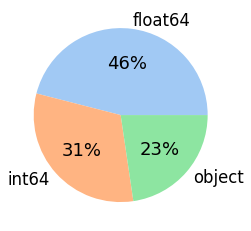

In [ ]:
print("Shape of our Dataframe, rows & columns: ", df.shape, "\n\r")
count_result = df.dtypes.value_counts() #we might have a fair amount of ints, floats and objects
print("Types of DataTypes within the DataFrame: ", count_result.size, "\n\r")
print("DISTRIBUTION AS FOLLOWS: ", "\n\r")
import matplotlib.pyplot as plt # Invoke MatPlotLib
import seaborn as sns # Invoke Seaborn
data = [count_result[0], count_result[1], count_result[2]] # Data
labels = [count_result.index[0], count_result.index[1], count_result.index[2]] # DataTypes
colors = sns.color_palette("pastel") # Look & Feel
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5}) # Font
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%') # PIE
plt.show() # Plot

Look for columns with a lot of NaN values, or as I call them, Ghost Features. I choose 50%. If we look closely, those features include member_id, inquiries, settlement data. That information is non-public or non mandatory so it is fair to take them out for this purpose. In a few words take tha noise out.

Total number of columns:  150 

Given the threshold 50  % NaN allowed, the total count of exceeding records is: 

dict_keys(['no', 'Yes'])  with the following counts:  dict_values([93, 57]) 

CHART - HOW MANY RECORDS EXCEED NAN % THRESHOLD 



<AxesSubplot:xlabel='exceeded', ylabel='Count'>

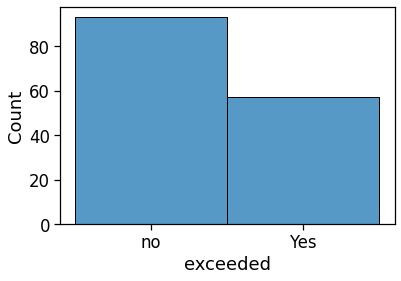

In [ ]:
from collections import Counter # Easy way to count

nanthreshold = 50 # % allowance limit of NaNs per column
missingseries = df.isna().mean().round(4)*100 # Series of % NaN per column
missingdf = pd.DataFrame(
    {'features': missingseries.keys(), 
     'percent':missingseries.values}) # Turn series to dataframe first
# Lets use lambda here (similar to if-then condition)
missingdf['exceeded'] = missingdf['percent'].apply(
    lambda x: 'Yes' if x >= nanthreshold else 'no') # quick classification

print("Total number of columns: ", len(missingdf['exceeded']),"\n\r")
print("Given the threshold", nanthreshold, " % NaN allowed, the total count of exceeding records is:","\n\r")
print(Counter(missingdf['exceeded']).keys(),
      " with the following counts: ",
      Counter(missingdf['exceeded']).values(),"\n\r")

print("CHART - HOW MANY RECORDS EXCEED NAN % THRESHOLD","\n\r")
sns.histplot(data=missingdf, x="exceeded", binwidth=3)

Totally empty features have something in common with columns with just 1 value in every row. Again, take the noise out.

In [ ]:
uniquedf = df.apply(pd.Series.nunique) # get unique value columns
singledf = uniquedf[uniquedf == 1].index.tolist() # list them
print("One-Value-Features: ", singledf)

One-Value-Features:  ['policy_code', 'application_type', 'hardship_type', 'deferral_term', 'hardship_length', 'disbursement_method']


# Data wrangling

## Haircut

Take out the following: 1) Columns with too many NaNs 2) One-Value-Only Features 3) List of variables not likely to be present during the negotiation session. For the last one, there is no other way than: Walk the process step by step and ask a Subject Matter Expert or Super User of the Process. In the end, fundamental analysis matters. For the case-by-case analysis please follow the next link: https://github.com/coyoacan/abc/blob/13d72313eaaeebab936a7de47c5f17faceb6fefa/DefaultPrediction_FeatureReview.txt

In [ ]:
columns_to_drop = list(missingseries[missingseries >= 85].index)
list_one_by_one = ['id', 'funded_amnt', 'funded_amnt_inv', 'grade', 'issue_d', 'pymnt_plan', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high',
 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq',
 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 
 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd',  'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl',
 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'hardship_flag',
 'debt_settlement_flag']
columns_to_drop = columns_to_drop + singledf + list_one_by_one
df = df.drop(columns_to_drop, axis=1)

Print the new distribution after removing features

NEW Shape of our Dataframe, rows & columns:  (100000, 23) 

Types of DataTypes within the DataFrame:  3 

DISTRIBUTION AS FOLLOWS:  



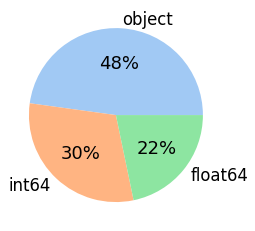

In [ ]:
print("NEW Shape of our Dataframe, rows & columns: ", df.shape, "\n\r")
count_result = df.dtypes.value_counts() #we might have a fair amount of ints, floats and objects
print("Types of DataTypes within the DataFrame: ", count_result.size, "\n\r")
print("DISTRIBUTION AS FOLLOWS: ", "\n\r")
data = [count_result[0], count_result[1], count_result[2]] # Data
labels = [count_result.index[0], count_result.index[1], count_result.index[2]] # DataTypes
colors = sns.color_palette("pastel") # Look & Feel
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5}) # Font
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%') # PIE
plt.show() # Plot

## Target variable

Out target row will be loan_status, we will only work with Fully Paid and Charged Off values. We need our Machine Learning model to find the "barrier" between these two outputs. Values: 'Current ', 'Late(31-120 days)', 'InGracePeriod', 'Late(16-30 days)' are ignored / discarded 

In [ ]:
df = df.loc[df['loan_status'].isin(['Fully Paid', 'Charged Off'])] #only rows with those values
print("By just selecting Fully Paid & Charged Off, we end up with the following shape: ", df.shape)

By just selecting Fully Paid & Charged Off, we end up with the following shape:  (86138, 23)


The curse of an inbalanced data set 💔

Count of Charge Offs is->  16156
Count of Full Payments is->  69982

---Let's visualize it graphically---



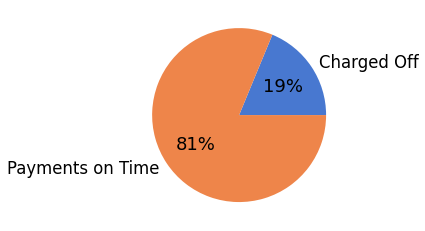

In [ ]:
count_co = df['loan_status'][df['loan_status'] == 'Charged Off'].count()
count_fp = df['loan_status'][df['loan_status'] == 'Fully Paid'].count()
print("Count of Charge Offs is-> ",
      count_co)
print("Count of Full Payments is-> ",
      count_fp)
print("\n\r---Let's visualize it graphically---\n\r")

#define data
data = [count_co, count_fp]
labels = ['Charged Off', 'Payments on Time']
#define Seaborn color palette to use
colors = sns.color_palette("muted")
#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

## Outliers

Looping through all numerical features and building a boxplot for each one we see some interesting things like annual income really above average. Given this, we are tempted to get rid of outliers, very high annual income or rev.balance. Outliers are part of UHNW clients or Premium Banking / Wealth Management, ergo, we cut those guys off

In [ ]:
print(df[["annual_inc","open_acc","revol_bal"]].describe().T)
df = df[df['annual_inc'] <= 200000] # Googled high income earners in US
df = df[df['open_acc'] <= 20] # Ever heard of a person opening 20 accounts?
df = df[df['revol_bal'] <= 200000] # Risk appetite may be around a year of income per client

              count          mean           std     min      25%        50%  \
annual_inc  86138.0  73843.112733  59293.516467  4000.0  45000.0  62473.725   
open_acc    86138.0     11.746453      5.433122     1.0      8.0     11.000   
revol_bal   86138.0  16893.430344  24390.313986     0.0   6144.0  11376.000   

                75%        max  
annual_inc  90000.0  7500000.0  
open_acc       14.0       84.0  
revol_bal   20383.0  2560703.0  


## Sampling

We make a balanced set by sampling 12k rows (replace=false) from both selected segments of the target variable. Why 12 thousand? I liked the number. Feel free to give another number if you like, just remember with replace=false there is a certain limit

In [ ]:
df_group = df.groupby('loan_status').apply(lambda x: x.sample(n=12000)).reset_index(drop = True)
df_group.loan_status.value_counts()

Charged Off    12000
Fully Paid     12000
Name: loan_status, dtype: int64

Count of Charge Offs is->  12000
Count of Full Payments is->  12000

---Let's visualize it graphically---



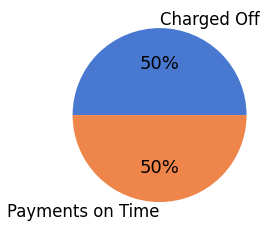

In [ ]:
count_co = df_group['loan_status'][df_group['loan_status'] == 'Charged Off'].count()
count_fp = df_group['loan_status'][df_group['loan_status'] == 'Fully Paid'].count()
print("Count of Charge Offs is-> ",
      count_co)
print("Count of Full Payments is-> ",
      count_fp)
print("\n\r---Let's visualize it graphically---\n\r")

#define data
data = [count_co, count_fp]
labels = ['Charged Off', 'Payments on Time']
#define Seaborn color palette to use
colors = sns.color_palette("muted")
#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

We would like to cast all object types into category. But first let us move the target feature to the last column and then do all that jazz

In [ ]:
new_cols = [col for col in df_group.columns if col != 'loan_status'] + ['loan_status']
df_group = df_group[new_cols] # new column order where target appears last
df_group = pd.concat([
        df_group.select_dtypes([], ['object']),
        df_group.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1)
df_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   loan_amnt             24000 non-null  int64   
 1   int_rate              24000 non-null  float64 
 2   installment           24000 non-null  float64 
 3   annual_inc            24000 non-null  float64 
 4   dti                   24000 non-null  float64 
 5   open_acc              24000 non-null  int64   
 6   pub_rec               24000 non-null  int64   
 7   revol_bal             24000 non-null  int64   
 8   revol_util            23986 non-null  float64 
 9   total_acc             24000 non-null  int64   
 10  mort_acc              24000 non-null  int64   
 11  pub_rec_bankruptcies  24000 non-null  int64   
 12  term                  24000 non-null  category
 13  sub_grade             24000 non-null  category
 14  emp_title             22463 non-null  category
 15  em

# A little peek into feature importance

## Classes

See what is inside the sample, if there is a number describe its mean, count and std. If what is inside the sample is an object, describe the most common value, unique values and so on.

In [ ]:
df_group.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,24000.0,14090.587500,8178.774294,1000.00,8000.00,12000.000,19750.0000,35000.00
int_rate,24000.0,14.051804,4.566545,6.00,10.99,13.980,16.9900,26.06
installment,24000.0,425.357757,240.880782,30.44,255.25,367.740,550.9425,1407.01
annual_inc,24000.0,66047.758431,33084.435586,4000.00,42000.00,60000.000,82000.0000,200000.00
dti,24000.0,19.226443,8.599246,0.00,12.72,18.725,25.3700,39.99
open_acc,24000.0,10.873583,4.031195,1.00,8.00,10.000,14.0000,20.00
pub_rec,24000.0,0.230750,0.593382,0.00,0.00,0.000,0.0000,15.00
revol_bal,24000.0,14815.054708,14924.019586,0.00,5914.75,10741.500,18801.2500,194056.00
revol_util,23986.0,56.159305,23.419125,0.00,39.00,56.700,74.2000,180.30
total_acc,24000.0,24.346375,10.900991,3.00,16.00,23.000,31.0000,95.00


In [ ]:
df_group.describe(include='category').T

,count,unique,top,freq
term,24000,2,36 months,17163
sub_grade,24000,35,C4,1400
emp_title,22463,11503,Manager,430
emp_length,22462,11,10+ years,7724
home_ownership,24000,3,MORTGAGE,10798
verification_status,24000,3,Source Verified,10064
purpose,24000,12,debt_consolidation,15016
title,24000,15,Debt consolidation,15022
zip_code,24000,818,750xx,255
addr_state,24000,46,CA,3499


In [ ]:
df_group.columns

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc',
       'pub_rec_bankruptcies', 'term', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'purpose', 'title', 'zip_code',
       'addr_state', 'loan_status'],
      dtype='object')

## Libraries for data pre-processing & code

I'm not going to spend too much time here, just a few comments on the following code. Pipelines need information in numbers,  for target variables we use LabelEncoder and for features we use OneHotEncoder (many columns 1 or 0) or OrdinalEncoder (same columns different num values). We also need imputers for missing values; those can be frequent values, mean, mode, et al. Feel free to experiment here, I'm not your boss.

In [ ]:
from timeit import default_timer # measure processing time :)
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot # Plot Features
from matplotlib.pyplot import figure # Look & Feel

### Making a pipeLine (this helps us speed things up)

In [ ]:
X = df_group.drop('loan_status',axis=1)
y = df_group['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=2022)

attributes_number = Pipeline(steps=[
    ('null_replacement', SimpleImputer(strategy='mean')),
    ('scaling', StandardScaler())
])

attributes_category = Pipeline(steps=[
    ('null_replacement', SimpleImputer(strategy='most_frequent')),
    ('encoding', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = -1))
])

columns_number = X_train.select_dtypes(include='number').columns.to_list()
columns_category = X_train.select_dtypes(include='category').columns.to_list()

attributes_preprocess = ColumnTransformer(transformers=[
    ('number', attributes_number, columns_number),
    ('category', attributes_category, columns_category)
])

label_encoding = LabelEncoder()
y_train = label_encoding.fit_transform(y_train)
y_test = label_encoding.fit_transform(y_test)

In [ ]:
import collections

In [ ]:
counter = collections.Counter(y_train)
counter


Counter({1: 8361, 0: 8439})

In [ ]:
counter = collections.Counter(y_test)
counter

Counter({1: 3639, 0: 3561})

Very important step we would like to change Charged Off from 0 to 1. On the other hand, Fully Paid from 1 to 0

## Many ways to look at feature importance

According to Jason Brownlee PhD "Feature importance refers to techniques that assign a score to input features based on how useful they are at predicting a target variable.There are many types and sources of feature importance scores, although popular examples include statistical correlation scores, coefficients calculated as part of linear models, decision trees, and permutation importance scores. Feature importance scores play an important role in a predictive modeling project, including providing insight into the data, insight into the model, and the basis for dimensionality reduction and feature selection that can improve the efficiency and effectiveness of a predictive model on the problem" (How to Calculate Feature Importance With Python, 2020, https://machinelearningmastery.com/calculate-feature-importance-with-python/)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from xgboost import XGBRegressor

### Linear Regression Feature Importance

Feature: 0, Score: 0.01442
Feature: 1, Score: -0.02309
Feature: 2, Score: -0.02261
Feature: 3, Score: 0.01238
Feature: 4, Score: -0.03413
Feature: 5, Score: -0.02249
Feature: 6, Score: -0.00358
Feature: 7, Score: 0.01813
Feature: 8, Score: -0.02053
Feature: 9, Score: 0.00426
Feature: 10, Score: 0.02155
Feature: 11, Score: -0.00692
Feature: 12, Score: -0.17663
Feature: 13, Score: -0.01309
Feature: 14, Score: -0.00001
Feature: 15, Score: -0.00065
Feature: 16, Score: -0.02242
Feature: 17, Score: -0.02539
Feature: 18, Score: -0.00232
Feature: 19, Score: 0.00549
Feature: 20, Score: 0.00000
Feature: 21, Score: -0.00012


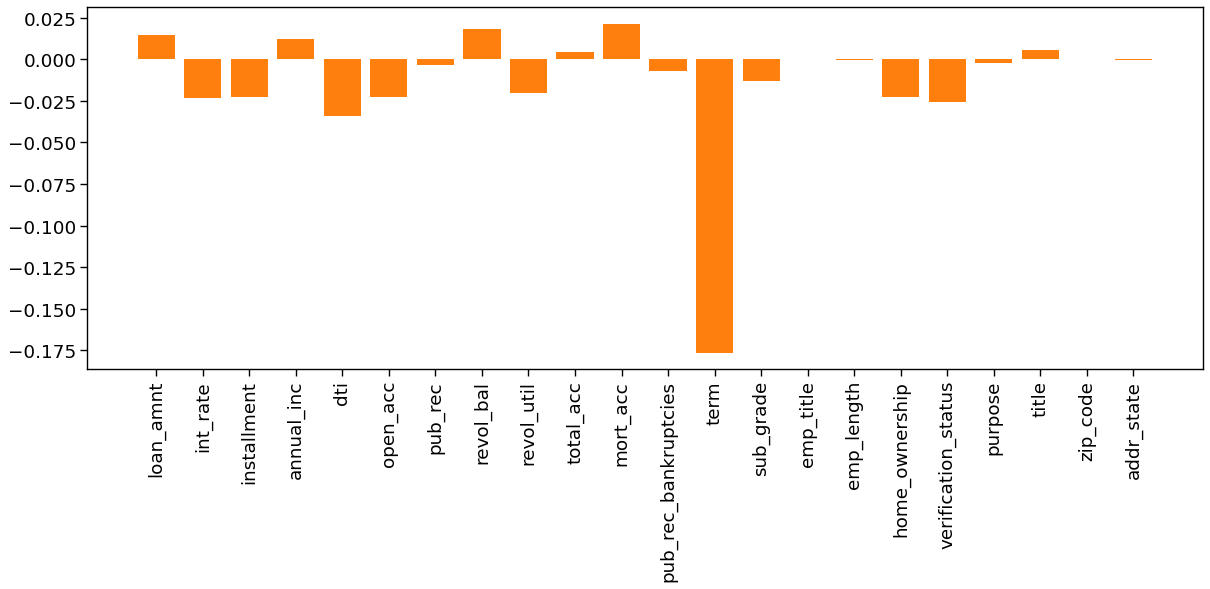

In [ ]:
# Linear Regression Feature Importance
model_pipeline = Pipeline(steps=[
    ('preprocess', attributes_preprocess),
    ('model', LinearRegression())
])

model_pipeline.fit(X_train, y_train)
importance = model_pipeline['model'].coef_

figure(figsize=(18, 6), dpi=80)

# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.bar(X_train.columns, importance)
pyplot.xticks(rotation=90)
pyplot.show()


### Logistic Regression Feature Importance

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Feature: 0, Score: -0.04664
Feature: 1, Score: -0.08885
Feature: 2, Score: -0.00531
Feature: 3, Score: 0.04537
Feature: 4, Score: -0.10977
Feature: 5, Score: -0.04760
Feature: 6, Score: -0.01040
Feature: 7, Score: 0.02038
Feature: 8, Score: -0.03712
Feature: 9, Score: -0.01250
Feature: 10, Score: 0.07509
Feature: 11, Score: -0.01331
Feature: 12, Score: -0.06431
Feature: 13, Score: -0.08220
Feature: 14, Score: 0.00002
Feature: 15, Score: -0.01845
Feature: 16, Score: -0.01922
Feature: 17, Score: -0.01070
Feature: 18, Score: 0.02650
Feature: 19, Score: 0.10911
Feature: 20, Score: 0.00049
Feature: 21, Score: 0.00852


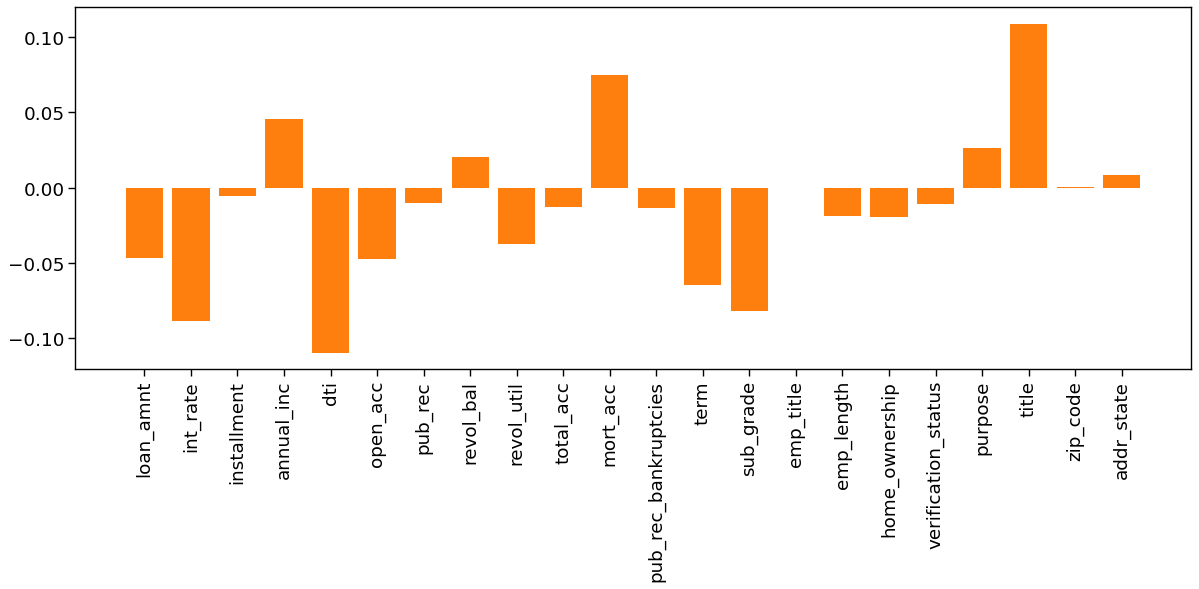

In [ ]:
# Logistic Regression Feature Importance
model_pipeline = Pipeline(steps=[
    ('preprocess', attributes_preprocess),
    ('model', LogisticRegression())
])

model_pipeline.fit(X_train, y_train)
importance = model_pipeline['model'].coef_[0] # this [0] is super important

figure(figsize=(18, 6), dpi=80)

# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.bar(X_train.columns, importance)
pyplot.xticks(rotation=90)
pyplot.show()

### Decision Tree Regressor

Feature: 0, Score: 0.03189
Feature: 1, Score: 0.04967
Feature: 2, Score: 0.05881
Feature: 3, Score: 0.06730
Feature: 4, Score: 0.08397
Feature: 5, Score: 0.04139
Feature: 6, Score: 0.01040
Feature: 7, Score: 0.07678
Feature: 8, Score: 0.07227
Feature: 9, Score: 0.05874
Feature: 10, Score: 0.02773
Feature: 11, Score: 0.00411
Feature: 12, Score: 0.02447
Feature: 13, Score: 0.11122
Feature: 14, Score: 0.07439
Feature: 15, Score: 0.03074
Feature: 16, Score: 0.01062
Feature: 17, Score: 0.01503
Feature: 18, Score: 0.01495
Feature: 19, Score: 0.01411
Feature: 20, Score: 0.07363
Feature: 21, Score: 0.04778


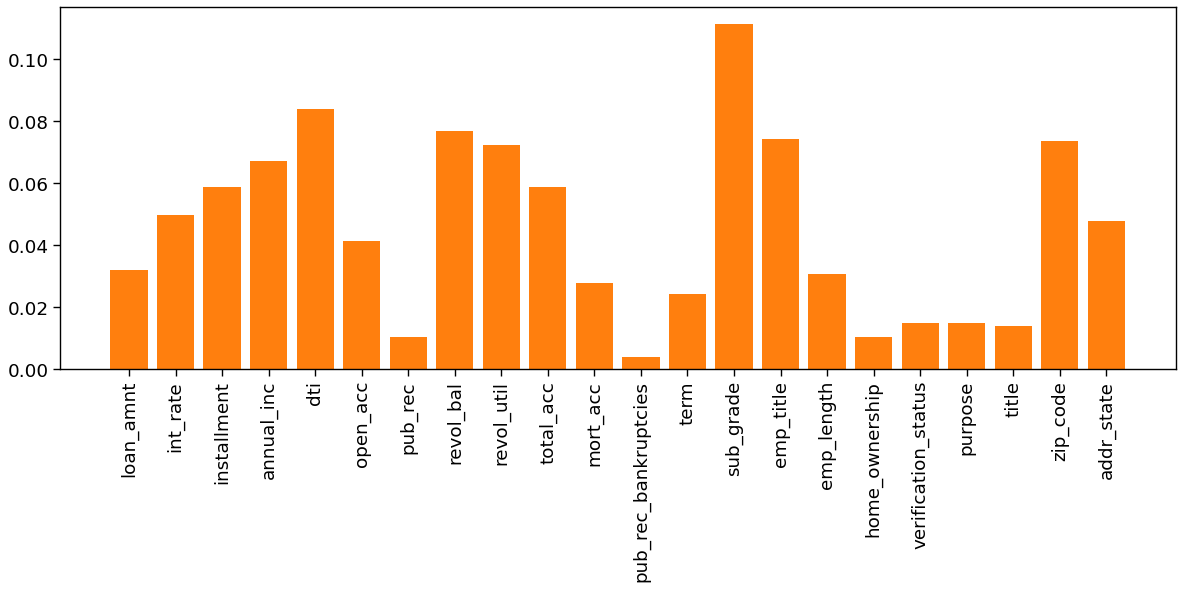

In [ ]:
# Decision Tree Regressor Feature Importance
model_pipeline = Pipeline(steps=[
    ('preprocess', attributes_preprocess),
    ('model', DecisionTreeRegressor())
])

model_pipeline.fit(X_train, y_train)
importance = model_pipeline['model'].feature_importances_ 
figure(figsize=(18, 6), dpi=80)

# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.bar(X_train.columns, importance)
pyplot.xticks(rotation=90)
pyplot.show()

### Decision Tree Classifier

Feature: 0, Score: 0.02968
Feature: 1, Score: 0.05132
Feature: 2, Score: 0.05721
Feature: 3, Score: 0.06821
Feature: 4, Score: 0.08586
Feature: 5, Score: 0.03995
Feature: 6, Score: 0.01061
Feature: 7, Score: 0.07333
Feature: 8, Score: 0.07620
Feature: 9, Score: 0.05898
Feature: 10, Score: 0.02718
Feature: 11, Score: 0.00491
Feature: 12, Score: 0.02447
Feature: 13, Score: 0.11151
Feature: 14, Score: 0.07247
Feature: 15, Score: 0.03519
Feature: 16, Score: 0.01030
Feature: 17, Score: 0.01553
Feature: 18, Score: 0.01247
Feature: 19, Score: 0.01368
Feature: 20, Score: 0.07362
Feature: 21, Score: 0.04732


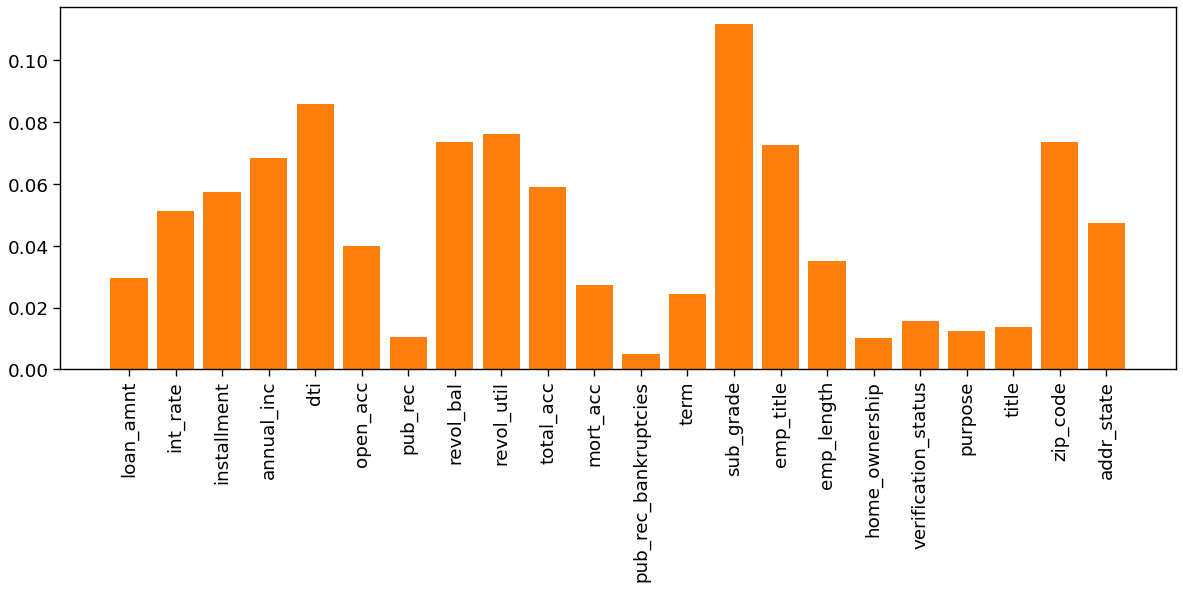

In [ ]:
# Decision Tree Classifier Feature Importance
model_pipeline = Pipeline(steps=[
    ('preprocess', attributes_preprocess),
    ('model', DecisionTreeClassifier())
])

model_pipeline.fit(X_train, y_train)
importance = model_pipeline['model'].feature_importances_ 
figure(figsize=(18, 6), dpi=80)

# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.bar(X_train.columns, importance)
pyplot.xticks(rotation=90)
pyplot.show()

### XGBoost Classifier

Feature: 0, Score: 0.01692
Feature: 1, Score: 0.04931
Feature: 2, Score: 0.01792
Feature: 3, Score: 0.01685
Feature: 4, Score: 0.01814
Feature: 5, Score: 0.01623
Feature: 6, Score: 0.01823
Feature: 7, Score: 0.01751
Feature: 8, Score: 0.01646
Feature: 9, Score: 0.01555
Feature: 10, Score: 0.02055
Feature: 11, Score: 0.01594
Feature: 12, Score: 0.16069
Feature: 13, Score: 0.46042
Feature: 14, Score: 0.01683
Feature: 15, Score: 0.01494
Feature: 16, Score: 0.01861
Feature: 17, Score: 0.02331
Feature: 18, Score: 0.01637
Feature: 19, Score: 0.01804
Feature: 20, Score: 0.01565
Feature: 21, Score: 0.01551


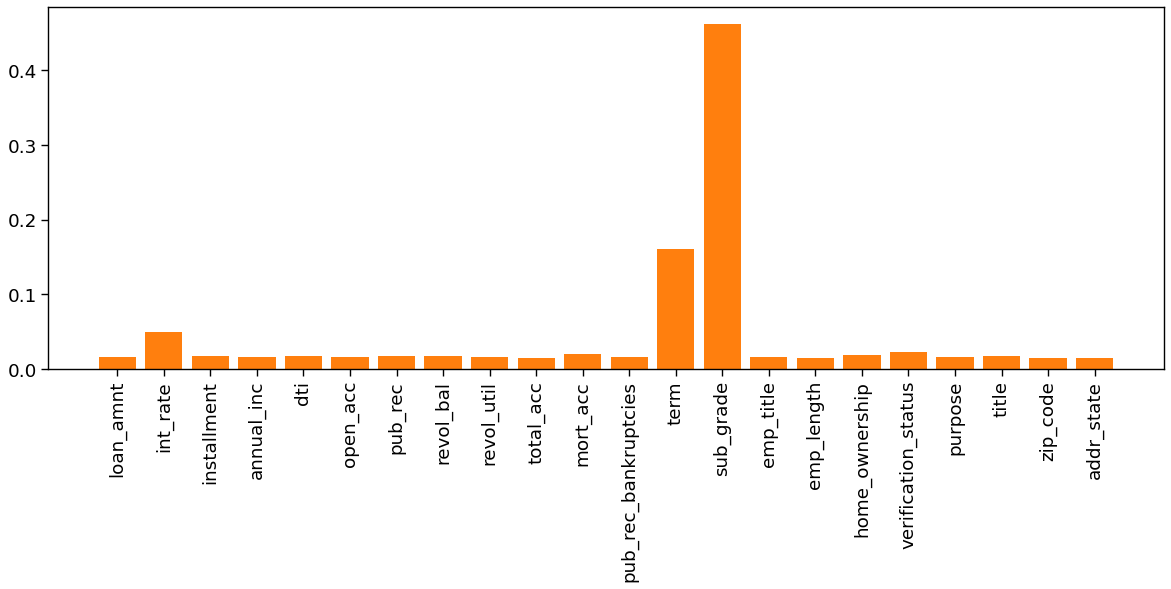

In [ ]:
# XGBoost Classifier Feature Importance
model_pipeline = Pipeline(steps=[
    ('preprocess', attributes_preprocess),
    ('model', XGBClassifier())
])

model_pipeline.fit(X_train, y_train)
importance = model_pipeline['model'].feature_importances_ 
figure(figsize=(18, 6), dpi=80)

# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.bar(X_train.columns, importance)
pyplot.xticks(rotation=90)
pyplot.show()

### XGBoost Regressor

Feature: 0, Score: 0.00775
Feature: 1, Score: 0.02778
Feature: 2, Score: 0.01488
Feature: 3, Score: 0.01236
Feature: 4, Score: 0.01441
Feature: 5, Score: 0.01253
Feature: 6, Score: 0.01493
Feature: 7, Score: 0.01471
Feature: 8, Score: 0.01398
Feature: 9, Score: 0.01368
Feature: 10, Score: 0.01667
Feature: 11, Score: 0.01192
Feature: 12, Score: 0.10679
Feature: 13, Score: 0.59998
Feature: 14, Score: 0.01419
Feature: 15, Score: 0.01300
Feature: 16, Score: 0.01881
Feature: 17, Score: 0.01733
Feature: 18, Score: 0.01166
Feature: 19, Score: 0.01479
Feature: 20, Score: 0.01294
Feature: 21, Score: 0.01491


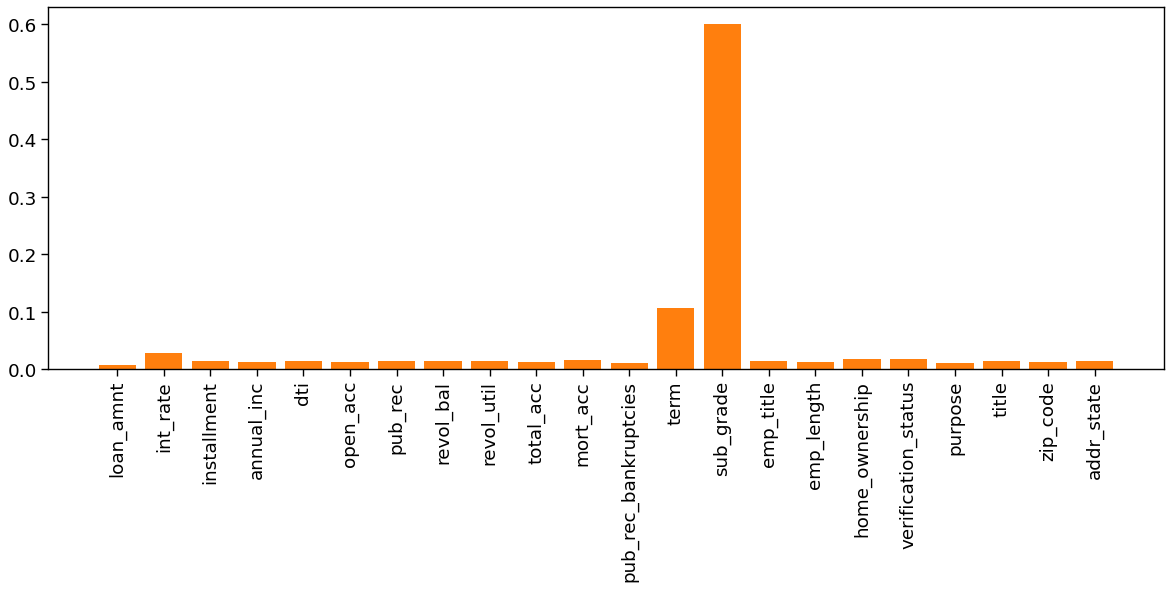

In [ ]:
# XGBoost Regressor Feature Importance
model_pipeline = Pipeline(steps=[
    ('preprocess', attributes_preprocess),
    ('model', XGBRegressor())
])

model_pipeline.fit(X_train, y_train)
importance = model_pipeline['model'].feature_importances_ 
figure(figsize=(18, 6), dpi=80)

# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.bar(X_train.columns, importance)
pyplot.xticks(rotation=90)
pyplot.show()

Fine, seems there is no solid consensus between previous approaches. Nevertheless, features such as grade, term, dti, loan amount always stand out, sounds logical to focus on them

# Modeling

## GridSearch Decision Tree Classifier

In [ ]:
from sklearn.model_selection import GridSearchCV # Before all the jazz

In [ ]:
model_pipeline = Pipeline(steps=[
                                 ('preprocesss', attributes_preprocess),
                                 ('model', DecisionTreeClassifier())                                 
]) 
#hace las combinaciones de los parámetros
#de manera interna Grid Search hacer todas las combinaciones
#Me dice cuál es la mejor combinación de hiperparámetros
#Se concatena model__ (model guión guión) porque se usa pipeline
#De no usarse un pipeline no se debe concatenar
params = [{
    'model__criterion':['gini','entropy','log_loss'],
    'model__max_depth':[5,7],    
}]

gs = GridSearchCV(model_pipeline, param_grid = params, scoring ='accuracy',cv=3,n_jobs =-1,verbose = 2)

In [ ]:
model_pipeline['model'].get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [ ]:
gs.fit(X_train,y_train)
gs.best_params_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


{'model__criterion': 'log_loss', 'model__max_depth': 5}

In [ ]:
# imprimir la mejor evaluación
gs.best_score_

0.6498214285714287

In [ ]:
# obtener el mejor modelo
best_model = gs.best_estimator_

In [ ]:
y_pred = best_model.predict(X_test)

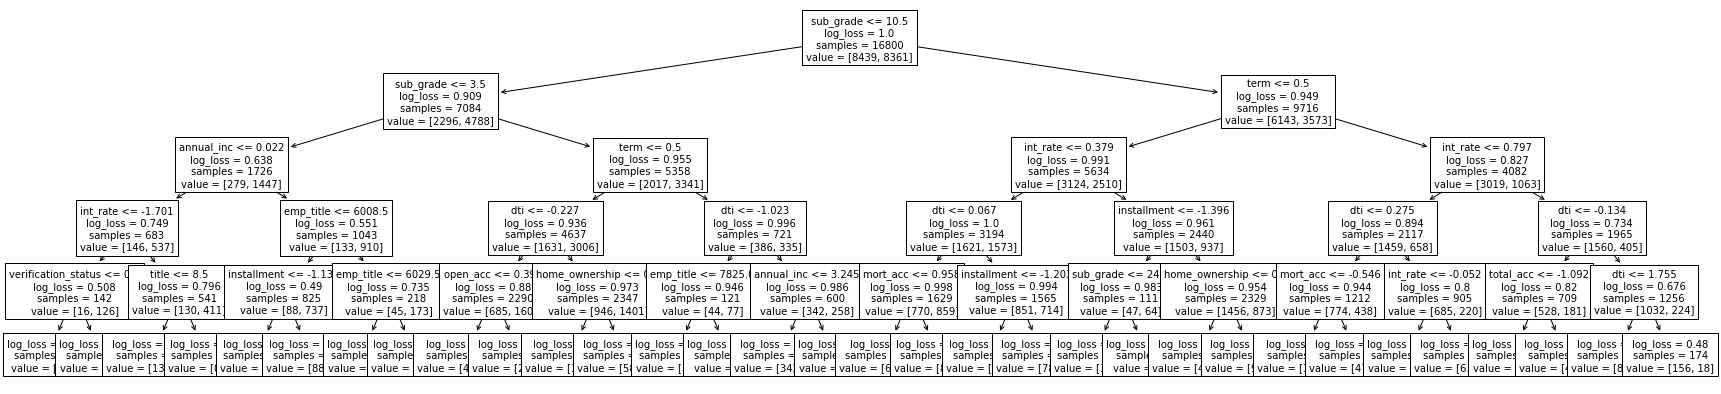

In [ ]:
from matplotlib.pylab import rcParams
from sklearn.tree import plot_tree, export_text
import matplotlib.pyplot as plt

rcParams['figure.figsize'] = 30,7

plot_tree(best_model['model'], feature_names=X_train.columns, fontsize= 10)
plt.show()

In [ ]:
print("mean accuracy (train): ", best_model.score(X_train,y_train))
print("mean accuracy (test): ", best_model.score(X_test,y_test))

mean accuracy (train):  0.6658928571428572
mean accuracy (test):  0.6508333333333334


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.64      0.65      0.65      3561
           1       0.66      0.65      0.65      3639

    accuracy                           0.65      7200
   macro avg       0.65      0.65      0.65      7200
weighted avg       0.65      0.65      0.65      7200



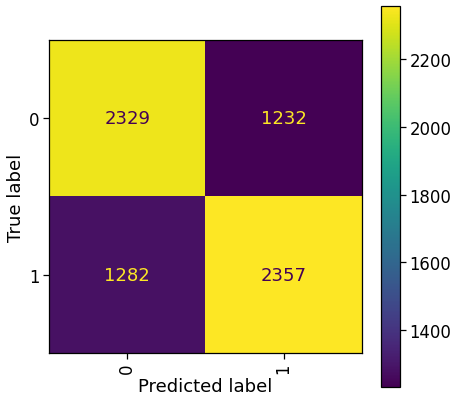

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

rcParams['figure.figsize'] = 7,7

ConfusionMatrixDisplay.from_predictions(y_test,y_pred, xticks_rotation='vertical')

plt.show()

## GridSearch XGBoost Classifier

In [ ]:
model_pipeline = Pipeline(steps=[
                                 ('preprocesss', attributes_preprocess),
                                 ('model', XGBClassifier())                                 
]) 
params = [{
    'model__max_depth':[5,10],
    'model__learning_rate':[0.01,0.05,0.1],    
}]

gs = GridSearchCV(model_pipeline, param_grid = params, scoring ='accuracy',cv=3,n_jobs =-1,verbose = 2)

In [ ]:
model_pipeline['model'].get_params().keys()

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'gamma', 'gpu_id', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_threshold', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [ ]:
gs.fit(X_train,y_train)
gs.best_params_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


{'model__learning_rate': 0.05, 'model__max_depth': 5}

In [ ]:
# imprimir la mejor evaluación
gs.best_score_

0.6606547619047619

mean accuracy (train):  0.7045833333333333
mean accuracy (test):  0.6568055555555555
              precision    recall  f1-score   support

           0       0.64      0.69      0.66      3561
           1       0.67      0.63      0.65      3639

    accuracy                           0.66      7200
   macro avg       0.66      0.66      0.66      7200
weighted avg       0.66      0.66      0.66      7200



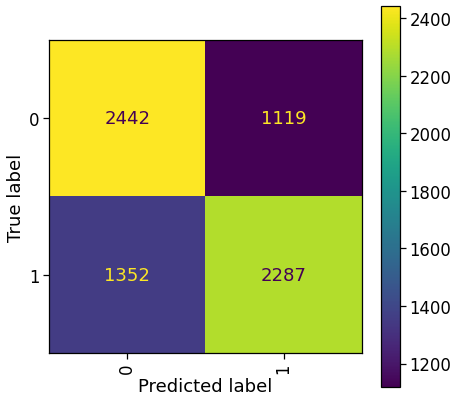

In [ ]:
# obtener el mejor modelo y su matriz de confusión
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)
print("mean accuracy (train): ", best_model.score(X_train,y_train))
print("mean accuracy (test): ", best_model.score(X_test,y_test))
print(classification_report(y_test,y_pred))

rcParams['figure.figsize'] = 7,7

ConfusionMatrixDisplay.from_predictions(y_test,y_pred, xticks_rotation='vertical')

plt.show()

## GridSearch Logistic Regression

In [ ]:
model_pipeline = Pipeline(steps=[
                                 ('preprocesss', attributes_preprocess),
                                 ('model', LogisticRegression())                                 
]) 
params = [{
    'model__C':[0.01,1,10],    
}]

gs = GridSearchCV(model_pipeline, param_grid = params, scoring ='accuracy',cv=3,n_jobs =-1,verbose = 2)

In [ ]:
model_pipeline['model'].get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [ ]:
gs.fit(X_train,y_train)
gs.best_params_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'model__C': 0.01}

In [ ]:
# imprimir la mejor evaluación
gs.best_score_

0.6525595238095239

mean accuracy (train):  0.65625
mean accuracy (test):  0.6513888888888889
              precision    recall  f1-score   support

           0       0.65      0.65      0.65      3561
           1       0.66      0.65      0.65      3639

    accuracy                           0.65      7200
   macro avg       0.65      0.65      0.65      7200
weighted avg       0.65      0.65      0.65      7200



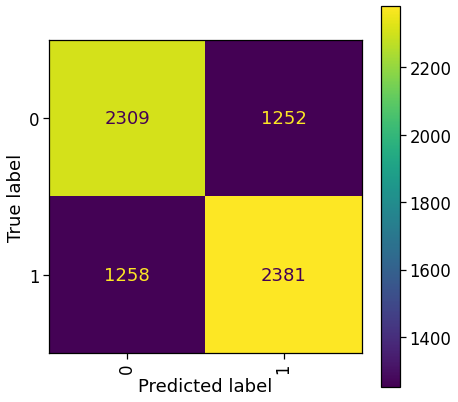

In [ ]:
# obtener el mejor modelo y su matriz de confusión
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)
print("mean accuracy (train): ", best_model.score(X_train,y_train))
print("mean accuracy (test): ", best_model.score(X_test,y_test))
print(classification_report(y_test,y_pred))

rcParams['figure.figsize'] = 7,7

ConfusionMatrixDisplay.from_predictions(y_test,y_pred, xticks_rotation='vertical')

plt.show()

## Support Vector Machine (No Grid Search)

In [ ]:
from sklearn.svm import SVC

In [ ]:
model_pipeline = Pipeline(steps=[
                                 ('preprocesss', attributes_preprocess),
                                 ('model', SVC())                                 
]) 

In [ ]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocesss',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('null_replacement',
                                                                   SimpleImputer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'int_rate',
                                                   'installment', 'annual_inc',
                                                   'dti', 'open_acc', 'pub_rec',
                                                   'revol_bal', 'revol_util',
                                                   'total_acc', 'mort_acc',
                                                   'pub_rec_bankruptcies']),
                                                 ('category',
                                                  Pipeline(steps=[('null_replacement',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoding',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['term', 'sub_grade',
                                                   'emp_title', 'emp_length',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'purpose', 'title',
                                                   'zip_code',
                                                   'addr_state'])])),
                ('model', SVC())])

In [ ]:
print('mean accuracy (train): ', model_pipeline.score(X_train, y_train))

mean accuracy (train):  0.5182142857142857


In [ ]:
print('mean accuracy (test): ', model_pipeline.score(X_test, y_test))

mean accuracy (test):  0.5095833333333334


In [ ]:
y_pred = model_pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.14      0.22      3561
           1       0.51      0.87      0.64      3639

    accuracy                           0.51      7200
   macro avg       0.51      0.51      0.43      7200
weighted avg       0.51      0.51      0.43      7200



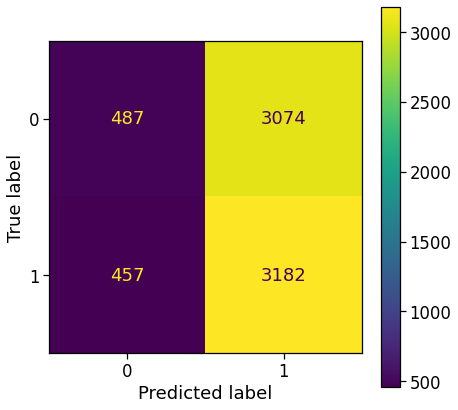

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

# Conclusions

## Sensitivity vs Specificity (ROC curve)

Receiver Operating Characteristic (ROC) & Area Under the Curve (AUC) A plot between Sensitivity & Specificity For more information: https://r.search.yahoo.com/_ylt=AwrFDYrCXA9kciQHTFjD8Qt.;_ylu=Y29sbwNiZjEEcG9zAzUEdnRpZAMEc2VjA3Ny/RV=2/RE=1678757187/RO=10/RU=https%3a%2f%2fwww.cambridge.org%2fcore%2fservices%2faop-cambridge-core%2fcontent%2fview%2fS1481803500013336/RK=2/RS=KGJl9TiboQzoHkKXBvgbj8xxU04-

In [ ]:
from sklearn import metrics

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


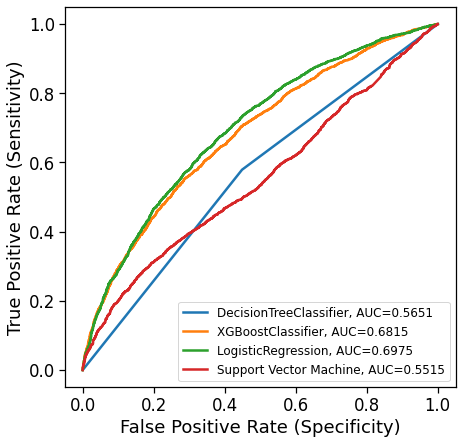

In [ ]:
#set up plotting area
plt.figure(0).clf()

# fit Decision Tree Classifier
model_pipeline = Pipeline(steps=[
                                 ('preprocesss', attributes_preprocess),
                                 ('model', DecisionTreeClassifier())                                 
])
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="DecisionTreeClassifier, AUC="+str(auc))

# fit XGBoost Classifier
model_pipeline = Pipeline(steps=[
                                 ('preprocesss', attributes_preprocess),
                                 ('model', XGBClassifier())                                 
])
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="XGBoostClassifier, AUC="+str(auc))

# fit Logistic Regression
model_pipeline = Pipeline(steps=[
                                 ('preprocesss', attributes_preprocess),
                                 ('model', LogisticRegression())                                 
])
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="LogisticRegression, AUC="+str(auc))

# fit Support Vector Machine
model_pipeline = Pipeline(steps=[
                                 ('preprocesss', attributes_preprocess),
                                 ('model', SVC(probability=True))                                 
])
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Support Vector Machine, AUC="+str(auc))

#add legend
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (Specificity)')
plt.legend(loc=4,prop={'size': 12})

## Closing Arguments & Findings

With a given ROC curve we can see `XGBoost Classifier` and `Logistic Regression` are two best choices to predict credit default from our testing. Nevertheless a ~0.60 AUC is not as good as it should be. More features are required.